In [17]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [18]:
# 파일 호출
data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [19]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:01<00:00, 60.24it/s]


In [20]:
print(df.columns)

Index(['ID', 'target', '_type',
       'hourly_market-data_coinbase-premium-index_coinbase_premium_gap',
       'hourly_market-data_coinbase-premium-index_coinbase_premium_index',
       'hourly_market-data_funding-rates_all_exchange_funding_rates',
       'hourly_market-data_funding-rates_binance_funding_rates',
       'hourly_market-data_funding-rates_bitmex_funding_rates',
       'hourly_market-data_funding-rates_bybit_funding_rates',
       'hourly_market-data_funding-rates_deribit_funding_rates',
       ...
       'hourly_network-data_hashrate_hashrate',
       'hourly_network-data_supply_supply_total',
       'hourly_network-data_supply_supply_new',
       'hourly_network-data_tokens-transferred_tokens_transferred_total',
       'hourly_network-data_tokens-transferred_tokens_transferred_mean',
       'hourly_network-data_tokens-transferred_tokens_transferred_median',
       'hourly_network-data_transactions-count_transactions_count_total',
       'hourly_network-data_transactions

In [21]:
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    'hourly_network-data_hashrate_hashrate': "hashrate_value",
    'hourly_network-data_transactions-count_transactions_count_total': 'transaction_count',
    'hourly_network-data_velocity_velocity_supply_total': 'velocity_count'
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 22)

In [22]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)

df['buy_volume_ma_3h'] = df['buy_volume'].rolling(window=3).mean()
df['buy_volume_std_3h'] = df['buy_volume'].rolling(window=3).std()

df['funding_rates_ma_3h'] = df['funding_rates'].rolling(window=3).mean()
df['funding_rates_std_3h'] = df['funding_rates'].rolling(window=3).std()

df['price_close_pct_change_1h'] = df['coinbase_premium_gap'].pct_change(periods=1)
df['price_close_pct_change_3h'] = df['coinbase_premium_gap'].pct_change(periods=3)

df['buy_volume_pct_change_1h'] = df['buy_volume'].pct_change(periods=1)
df['buy_volume_pct_change_3h'] = df['buy_volume'].pct_change(periods=3)

df['liquidation_diff_pct_change_3h'] = df['liquidation_diff'].pct_change(periods=3)

df['buy_sell_ratio_pct_change_3h'] = df['buy_sell_ratio'].pct_change(periods=3)
df['is_buy_dominant'] = (df['buy_sell_ratio'] > 1.0).astype(int)


# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio", "liquidation_diff", "liquidation_usd_diff", "volume_diff",
    "buy_volume_ma_3h", "buy_volume_std_3h", "funding_rates_ma_3h", "funding_rates_std_3h",
    "price_close_pct_change_1h", "price_close_pct_change_3h", "buy_volume_pct_change_1h", "buy_volume_pct_change_3h",
    "liquidation_diff_pct_change_3h", "buy_sell_ratio_pct_change_3h", "is_buy_dominant",
]

In [23]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [24]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [25]:
print(train_df.head())

                    ID  target  coinbase_premium_gap  coinbase_premium_index  \
0  2023-01-01 00:00:00     2.0                 -9.86               -0.059650   
1  2023-01-01 01:00:00     1.0                 -8.78               -0.053047   
2  2023-01-01 02:00:00     1.0                 -9.59               -0.057952   
3  2023-01-01 03:00:00     1.0                 -9.74               -0.058912   
4  2023-01-01 04:00:00     2.0                -10.14               -0.061373   

   funding_rates  long_liquidations  long_liquidations_usd  \
0       0.005049              0.012              197.51610   
1       0.005049              0.000                0.00000   
2       0.005049              0.000                0.00000   
3       0.005067              0.593             9754.76891   
4       0.006210              0.361             5944.43714   

   short_liquidations  short_liquidations_usd  open_interest  ...  \
0               0.000                 0.00000   6.271344e+09  ...   
1       

In [26]:
def window_slicing(df: pd.DataFrame, window_size: int, step_size: int) -> pd.DataFrame:
    sliced_data = []
    
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window_df = df.iloc[start:end].copy()
        # window_df['window_start_index'] = start
        sliced_data.append(window_df)
    
    sliced_data_df = pd.concat(sliced_data, axis=0).reset_index(drop=True)
    return sliced_data_df

window_size = 24
step_size = 12

train_0_3 = train_df[train_df['target'].isin([0, 3])]
train_1_2 = train_df[~train_df['target'].isin([0, 3])]

augm_0_3 = window_slicing(train_0_3, window_size=window_size, step_size=step_size)

#train_df_aug_window = pd.concat([train_1_2, augm_0_3], axis=0)

In [27]:
def noise_injection(df: pd.DataFrame, noise_level: float = 0.01, decay: float = 0.99, seed:int = 42) -> pd.DataFrame:
    np.random.seed(seed)
    df_noisy = df.copy()
    time_steps = np.arange(len(df_noisy))
    for col in df_noisy.select_dtypes(include=[np.number]).columns:
        noise = np.random.normal(0, noise_level*df_noisy[col].std(), size=df_noisy[col].shape)
        decays = decay ** time_steps
        df_noisy[col] = df_noisy[col] + noise * decays
    
    return df_noisy    

#train03 = train_df[train_df['target'].isin([0, 3])]

df_noisy = noise_injection(augm_0_3.drop(columns=['target', 'ID']))
df_noisy = df_noisy.reset_index(drop=True)
augm03 = augm_0_3.reset_index(drop=True) 
df_noisy['target'] = augm03['target'].values
df_noisy['ID'] = augm03['ID'].values

train_df_augm = pd.concat([train_1_2, df_noisy], axis=0)


In [28]:
# print(len(df_noisy))  # df_noisy의 길이 확인
# # print(len(train03)) 

In [29]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df_augm.drop(["target", "ID"], axis = 1), 
    train_df_augm["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

c:\Users\SAMSUNG\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's multi_logloss: 1.24276
[2]	valid_0's multi_logloss: 1.19308
[3]	valid_0's multi_logloss: 1.14955
[4]	valid_0's multi_logloss: 1.11119
[5]	valid_0's multi_logloss: 1.07577
[6]	valid_0's multi_logloss: 1.04421
[7]	valid_0's multi_logloss: 1.01471
[8]	valid_0's multi_logloss: 0.98781
[9]	valid_0's multi_logloss: 0.963061
[10]	valid_0's multi_logloss: 0.940177
[11]	valid_0's multi_logloss: 0.919381
[12]	valid_0's multi_logloss: 0.899035
[13]	valid_0's multi_logloss: 0.882032
[14]	valid_0's multi_logloss: 0.864895
[15]	valid_0's multi_logloss: 0.848802
[16]	valid_0's multi_logloss: 0.83421
[17]	valid_0's multi_logloss: 0.820761
[18]	valid_0's multi_logloss: 0.807476
[19]	valid_0's multi_logloss: 0.794977
[20]	valid_0's multi_logloss: 0.783131
[21]	valid_0's multi_logloss: 0.773159
[22]	valid_0's multi_logloss: 0.76

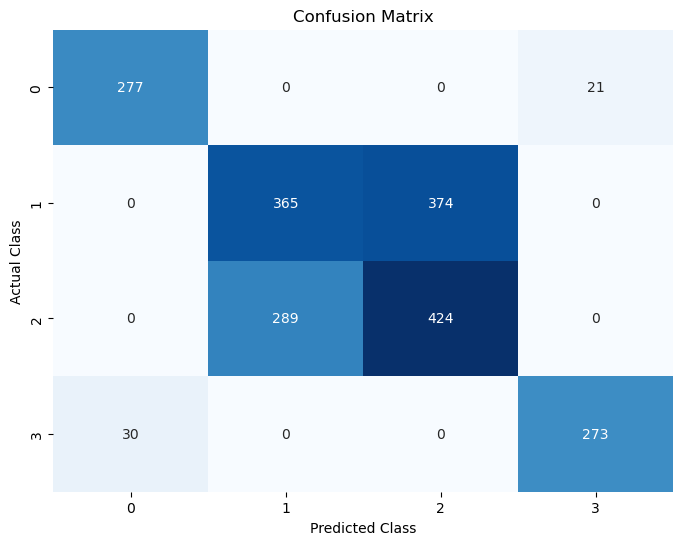

In [30]:
#print(train_df_augm)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)
conf_matrix = confusion_matrix(y_valid, y_valid_pred_class)

 # Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

In [31]:
importance = lgb_model.feature_importance()
feature_names=train_df.drop(["target", "ID"], axis = 1).columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort by importance (optional)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(feature_importance_df[:30])

                             Feature  Importance
34    liquidation_diff_pct_change_3h         121
21                       volume_diff          42
3                  long_liquidations          32
32          buy_volume_pct_change_1h          30
543                    volume_diff_1          29
371                receiver_count_13          29
19                  liquidation_diff          25
377                receiver_count_19          24
548                    volume_diff_6          24
737      buy_volume_pct_change_3h_11          23
718      buy_volume_pct_change_1h_15          23
712       buy_volume_pct_change_1h_9          23
668     price_close_pct_change_1h_11          23
370                receiver_count_12          22
372                receiver_count_14          22
640           funding_rates_std_3h_6          21
723      buy_volume_pct_change_1h_20          21
721      buy_volume_pct_change_1h_18          20
412                 hashrate_value_8          20
655          funding

In [32]:
target_ratio_total = train_df_augm["target"].value_counts(normalize=True)

target_ratio_train = y_train.value_counts(normalize=True)

target_ratio_valid = y_valid.value_counts(normalize=True)

print("total data target", target_ratio_total)
print("train data target", target_ratio_train)
print("valid data target", target_ratio_valid)

total data target target
2.0    0.357693
1.0    0.345318
3.0    0.154438
0.0    0.142551
Name: proportion, dtype: float64
train data target target
2    0.360292
1    0.341657
3    0.156151
0    0.141900
Name: proportion, dtype: float64
valid data target target
1    0.359961
2    0.347297
3    0.147589
0    0.145153
Name: proportion, dtype: float64


In [33]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df_augm.drop(["target", "ID"], axis = 1)
y_train = train_df_augm["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

c:\Users\SAMSUNG\anaconda3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055265 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [34]:
# lgb predict
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [35]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("self1.csv", index=False)

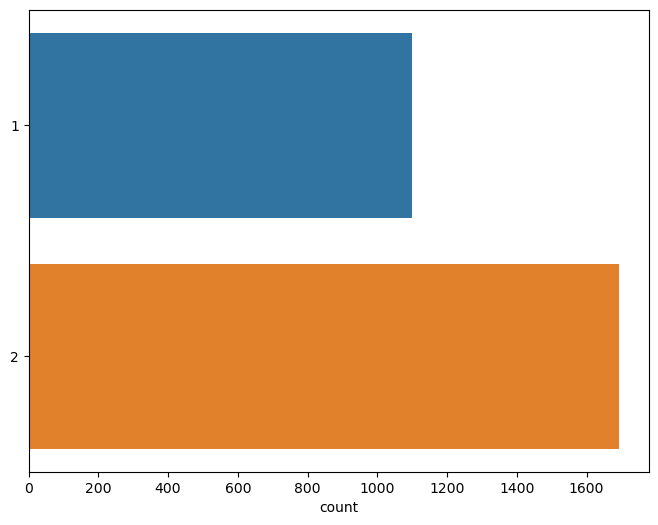

In [37]:
plt.figure(figsize=(8, 6))
sns.countplot(y=y_test_pred_class, order=np.unique(y_test_pred_class))
plt.show()

In [36]:
X_train_data = train_data.data
y_train_label = train_data.label

# 2. 데이터프레임으로 변환하여 확인
train_df = pd.DataFrame(X_train_data, columns=x_train.columns)
train_df['target'] = y_train_label

print(train_df.tail())

      coinbase_premium_gap coinbase_premium_index funding_rates  \
10258                  NaN                    NaN           NaN   
10259                  NaN                    NaN           NaN   
10260                  NaN                    NaN           NaN   
10261                  NaN                    NaN           NaN   
10262                  NaN                    NaN           NaN   

      long_liquidations long_liquidations_usd short_liquidations  \
10258               NaN                   NaN                NaN   
10259               NaN                   NaN                NaN   
10260               NaN                   NaN                NaN   
10261               NaN                   NaN                NaN   
10262               NaN                   NaN                NaN   

      short_liquidations_usd open_interest buy_ratio buy_sell_ratio  ...  \
10258                    NaN           NaN       NaN            NaN  ...   
10259                    NaN        

window slicing -> acc: 0.47735021919142717, auroc: 0.7850269840520915

window slicing + noise injection acc: 0.5232853513971211, auroc: 0.8128695283409264

window slicing 후 noise injection acc: 0.5428082191780822, auroc: 0.8135914100882286
                                
                                0.5801266439357039, auroc: 0.8530677400461201


# 24시간 기준으로 시간 정보 추가
# 요일 정보 추가 (7일로 나눠서)
# 주말 여부 추가 (토요일(5), 일요일(6)을 주말로 간주)

# 이전 윈도우와의 차이 계산
-> 거래량 
가격 변동등